In [60]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def replace_price_ticks(ax, xaxis, label):
    ticks = np.arange(0, 9e5, 1e5)
    labels = [str(int(round(t/1e3,0))) for t in ticks]
    if xaxis:
        ax.set_xticks(ticks, labels)
        ax.set_xlabel(f'{label} / 10$^3\\times$USD')
    else:
        ax.set_yticks(ticks, labels)
        ax.set_ylabel(f'{label} / 10$^3\\times$USD')

def convert_strings(num, base):
    length = int(np.floor(np.log10(num)))
    if length < base:
        s = '0'+str(round(num, -(base-2)))[:2]
    elif length == base:
        s = str(round(num, -(base-2)))[:3]
    else:
        raise ValueError('The length of the number to round is larger')
    return '{}.{}E+{:02d}'.format(s[0], s[1:], base)

error_text = '''\
- Average sale price: {}
- Mean absolute error: {}
- Median absolute error: {}
- Root mean squared error: {}
- R Squared: {:.4f}\
'''

errors = {}
alphas = {}
test_preds = {}
models = {}

# Get data

Read the data from the CSV file that we generated in the pre-processing step and make sure that
there are no null values in the data.\

In [3]:
dtypes = dict(MSSubClass=str)
df = pd.read_csv(os.path.join('data', 'ames-data-no-missing.csv'), index_col=0)

In [4]:
np.where(df.isnull().any())

(array([], dtype=int64),)

# Split up data

Split up the data set into the features, `X`, and labels, `y`. Then create a train/test split keeping
15% of the data as the testing data. Normally, it can be better to have a training set that is around
30% of the entire data set. However, I am using cross validation to tune the hyper-parameters in the
model and the *test* set is going to be a hold-out testing data set that I will use for reporting
the error metrics after the cross-validation step has been completed.

In [5]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Scale the data

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Generate models and run cross-validation steps

Now I will use the scaled training data and train the models using the
`RidgeCV` model in the `linear_regression` module in scikit-learn. This
will let me more easily tune the hyper-parameter, $\alpha$, rather than
running a grid search. The reason I am doing this is that `RidgeCV` will
use a scoring function to determine the best hyper-parameter. This is
more of a curiosity of mine to see how the scoring actually affects the
final results from training the model.

## Mean Absolute Error

Here we use the mean absolute error as the scoring metric in the training step.

In [8]:
model = RidgeCV(alphas=np.arange(0.1, 1000, 0.1), scoring='neg_mean_absolute_error')

In [9]:
model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.997e+02, 9.998e+02,
       9.999e+02]),
        scoring='neg_mean_absolute_error')

In [10]:
models['MAE'] = model
alphas['MAE'] = model.alpha_
model.alpha_

354.50000000000006

In [11]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)
errors['MAE'] = dict(MAE=MAE, MSE=MSE, RMSE=RMSE,
                       r2=r2, MedAE=MedAE, MAPerE=MAPerE)
print(error_text.format(y_test.mean(), MAE, RMSE, MedAE, r2))
test_preds['MAE'] = test_predictions

- Average actual price: 181122.35616438356
- Mean absolute error: 17968.776853455747
- Median absolute error: 27429.243295346314
- Root mean squared error: 12030.073612406268
- R2 score: 0.8862


## Mean Squared Error or Root Mean Squared Error

Here we use the mean squared error as the scoring metric in the training step.
According to the documentation on scikit-learn, if you want to use the root mean
squared error as the scoring metric you end up just using mean squared error.
Which makes sense honestly.

In [14]:
model = RidgeCV(alphas=np.arange(0.1, 1000, 0.1), scoring='neg_mean_squared_error')

In [15]:
model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.997e+02, 9.998e+02,
       9.999e+02]),
        scoring='neg_mean_squared_error')

In [16]:
models['MSE'] = model
alphas['MSE'] = model.alpha_
model.alpha_

190.20000000000002

In [17]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)
errors['MSE'] = dict(MAE=MAE, MSE=MSE, RMSE=RMSE,
                       r2=r2, MedAE=MedAE, MAPerE=MAPerE)
errors['RMSE'] = dict(MAE=MAE, MSE=MSE, RMSE=RMSE,
                       r2=r2, MedAE=MedAE, MAPerE=MAPerE)
print(error_text.format(y_test.mean(), MAE, RMSE, MedAE, r2))
test_preds['MSE'] = test_predictions

- Average actual price: 181122.35616438356
- Mean absolute error: 17800.464678315286
- Median absolute error: 26865.08043354498
- Root mean squared error: 12640.221589879773
- R2 score: 0.8909


## R Squared (coefficient of determination)

Here we use R squared as the scoring metric in the training step.

In [20]:
model = RidgeCV(alphas=np.arange(0.1, 1000, 0.1), scoring='r2')

In [21]:
model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.997e+02, 9.998e+02,
       9.999e+02]),
        scoring='r2')

In [22]:
models['r2'] = model
alphas['r2'] = model.alpha_
model.alpha_

190.20000000000002

In [23]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)
errors['r2'] = dict(MAE=MAE, MSE=MSE, RMSE=RMSE,
                       r2=r2, MedAE=MedAE, MAPerE=MAPerE)
print(error_text.format(y_test.mean(), MAE, RMSE, MedAE, r2))
test_preds['r2'] = test_predictions

- Average actual price: 181122.35616438356
- Mean absolute error: 17800.464678315286
- Median absolute error: 26865.08043354498
- Root mean squared error: 12640.221589879773
- R2 score: 0.8909


In [24]:
base = int(np.floor(np.log10(y_test.mean())))
str_vals = [convert_strings(y_test.mean(), base),
            convert_strings(MAE, base),
            convert_strings(MedAE, base),
            convert_strings(RMSE, base),
            r2]

## Median Absolute Error

Here we use the median absolute error as the scoring metric in the training step.

In [26]:
model = RidgeCV(alphas=np.arange(0.1, 1000, 0.1), scoring='neg_median_absolute_error')

In [27]:
model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.997e+02, 9.998e+02,
       9.999e+02]),
        scoring='neg_median_absolute_error')

In [28]:
models['MedAE'] = model
alphas['MedAE'] = model.alpha_
model.alpha_

748.8000000000001

In [29]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)
errors['MedAE'] = dict(MAE=MAE, MSE=MSE, RMSE=RMSE,
                       r2=r2, MedAE=MedAE, MAPerE=MAPerE)
print(error_text.format(y_test.mean(), MAE, RMSE, MedAE, r2))
test_preds['MedAE'] = test_predictions

- Average actual price: 181122.35616438356
- Mean absolute error: 18385.122105084753
- Median absolute error: 28675.4984639837
- Root mean squared error: 11674.233991310466
- R2 score: 0.8757


In [30]:
base = int(np.floor(np.log10(y_test.mean())))
str_vals = [convert_strings(y_test.mean(), base),
            convert_strings(MAE, base),
            convert_strings(MedAE, base),
            convert_strings(RMSE, base),
            r2]

## Mean Absolute Percentage Error

Here we use the mean absolute percentage error as the scoring metric in the training step.

In [32]:
model = RidgeCV(alphas=np.arange(500, 1500, 0.1), scoring='neg_mean_absolute_percentage_error')

In [33]:
model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([ 500. ,  500.1,  500.2, ..., 1499.7, 1499.8, 1499.9]),
        scoring='neg_mean_absolute_percentage_error')

In [34]:
models['MAPerE'] = model
alphas['MAPerE'] = model.alpha_
model.alpha_

1024.2000000001192

In [35]:
test_predictions = model.predict(X_test_scaled)
MAE = metrics.mean_absolute_error(y_test, test_predictions)
MSE = metrics.mean_squared_error(y_test, test_predictions)
RMSE = np.sqrt(MSE)
r2 = metrics.r2_score(y_test, test_predictions)
MedAE = metrics.median_absolute_error(y_test, test_predictions)
MAPerE = metrics.mean_absolute_percentage_error(y_test, test_predictions)
errors['MAPerE'] = dict(MAE=MAE, MSE=MSE, RMSE=RMSE,
                       r2=r2, MedAE=MedAE, MAPerE=MAPerE)
print(error_text.format(y_test.mean(), MAE, RMSE, MedAE, r2))
test_preds['MAPerE'] = test_predictions

- Average actual price: 181122.35616438356
- Mean absolute error: 18686.612030046104
- Median absolute error: 29491.293505356312
- Root mean squared error: 12247.609174257523
- R2 score: 0.8685


# Analyzing error metrics

In [80]:
error_df = pd.DataFrame.from_dict(errors).T
ndf = pd.concat([error_df, pd.Series(alphas.values(), index=alphas.keys(), name='alpha')], axis=1)
ndf.index.name = 'scoring'
ndf.columns.name = 'metric'
ndf

metric,MAE,MSE,RMSE,r2,MedAE,MAPerE,alpha
scoring,,,,,,,
MAE,17968.776853,7.523634e+08,27429.243295,0.886246,12030.073612,0.108136,354.5
MSE,17800.464678,7.217325e+08,26865.080434,0.890877,12640.221590,0.108687,190.2
RMSE,17800.464678,7.217325e+08,26865.080434,0.890877,12640.221590,0.108687,NaN
r2,17800.464678,7.217325e+08,26865.080434,0.890877,12640.221590,0.108687,190.2
MedAE,18385.122105,8.222842e+08,28675.498464,0.875674,11674.233991,0.108510,748.8
MAPerE,18686.612030,8.697364e+08,29491.293505,0.868499,12247.609174,0.109258,1024.2


## Plotting error metrics

Below is a plot of the error metric values as a function of
the scoring metric that we used in the training step.

The acronyms are:
- MAE: Mean Absolute Error
- MSE: Mean Squared Error
- RMSE: Root Mean Squared Error (not exactly using it as a
  scoring metric when training the model just wanted to make
  a better comparison to MAE)
- r2: R Squared
- MedAE: Median Absolute Error
- MAPerE: Mean Absolute Percentage Error

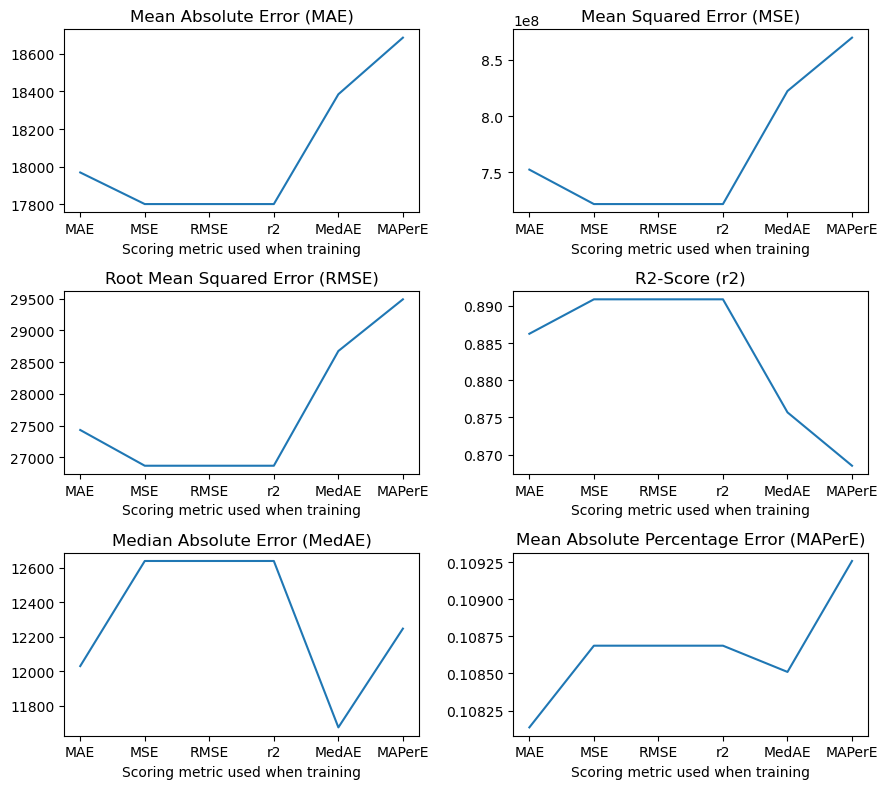

In [39]:
mapper = dict(MAE='Mean Absolute Error (MAE)', MSE='Mean Squared Error (MSE)',
              RMSE='Root Mean Squared Error (RMSE)', r2='R Squared (r2)',
              MedAE='Median Absolute Error (MedAE)',
              MAPerE='Mean Absolute Percentage Error (MAPerE)')
# error_df.drop('MAPerE', axis=0, inplace=True)
# error_df.drop('MAPerE', axis=1, inplace=True)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,8))
ax = np.ndarray.flatten(ax)
for i, col in enumerate(error_df.columns):
    d = error_df[col]
    ax[i].plot(d.index, d)
    ax[i].set_title(mapper[col])
    ax[i].set_xlabel('Scoring metric used when training')
fig.tight_layout()

## Plotting real vs. predicted values

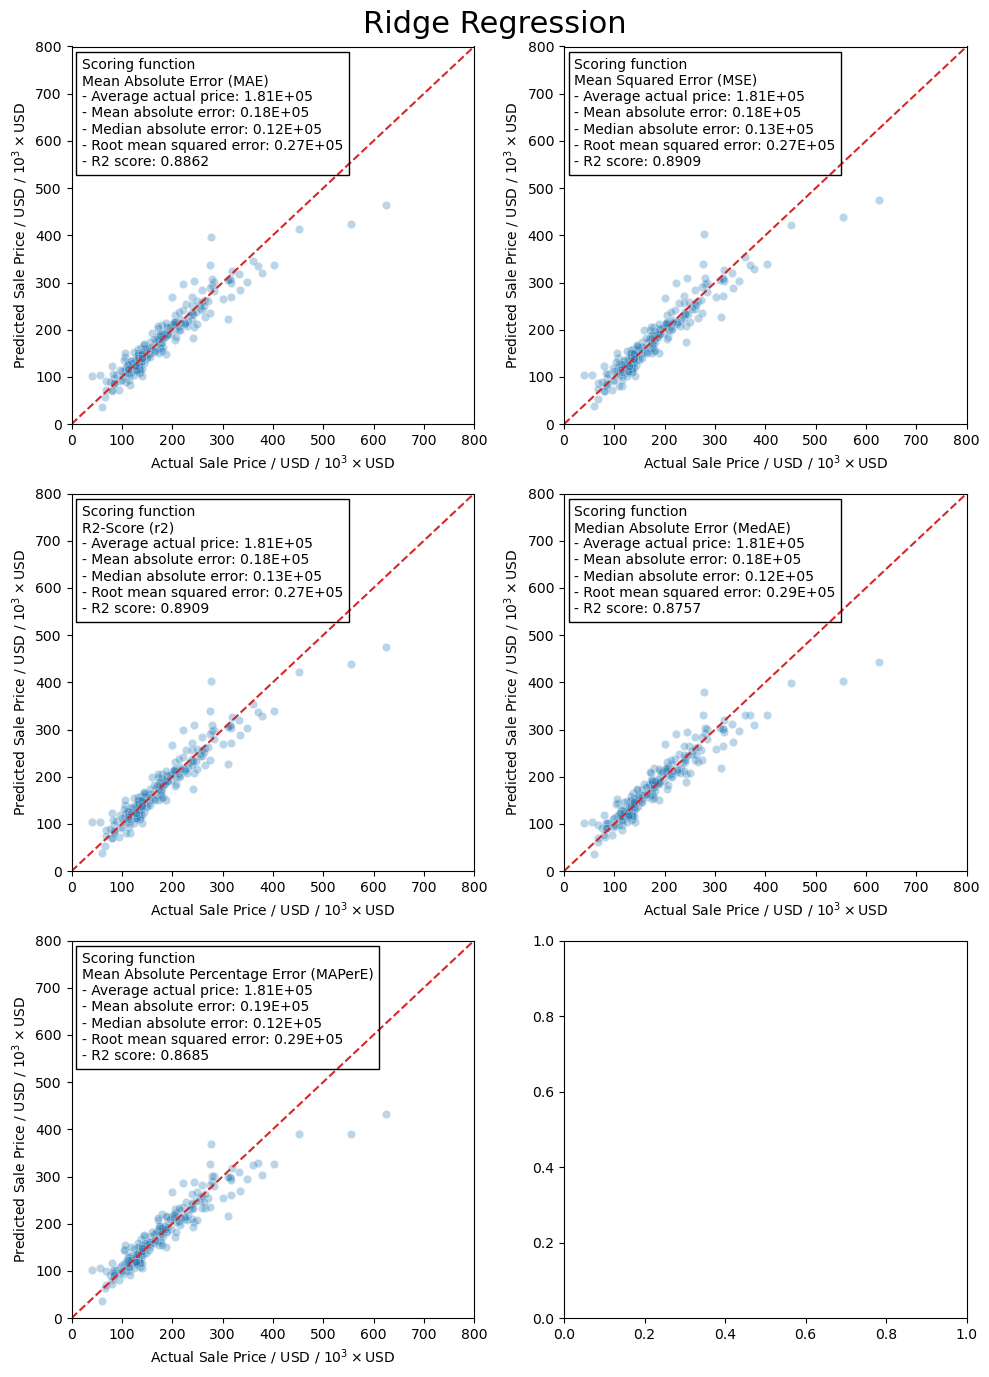

In [59]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 14))
ax = np.ndarray.flatten(ax)
base = int(np.floor(np.log10(y_test.mean())))
for idx, (key, value) in enumerate(test_preds.items()):
    str_vals = [convert_strings(y_test.mean(), base),
                convert_strings(errors[key]['MAE'], base),
                convert_strings(errors[key]['MedAE'], base),
                convert_strings(errors[key]['RMSE'], base),
                errors[key]['r2']]
    sns.scatterplot(x=y_test, y=value, alpha=0.3, ax=ax[idx])
    replace_price_ticks(ax[idx], True, 'Actual Sale Price / USD')
    replace_price_ticks(ax[idx], False, 'Predicted Sale Price / USD')
    xlim = ax[idx].get_xlim()
    new_lim = list(ax[idx].get_ylim())
    if new_lim[0] > xlim[0]: new_lim[0] = xlim[0]
    if new_lim[1] < xlim[1]: new_lim[1] = xlim[1]
    ax[idx].set_ylim(new_lim)
    ax[idx].set_xlim(new_lim)
    ax[idx].plot(new_lim, new_lim, color='tab:red', linestyle='--')
    ax[idx].text(s='Scoring function\n{}\n'.format(mapper[key])+error_text.format(*str_vals), x=0.025, y=0.97,
               transform=ax[idx].transAxes, ha='left', va='top',
               bbox=dict(fc='none'))
    # ax[idx].set_title('Scoring function\n{}\n'.format(mapper[key]))
fig.suptitle('Ridge Regression', fontsize=22)
fig.tight_layout()
fig.savefig(os.path.join('data', 'ridge.png'), dpi=500)